In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook as tqdm

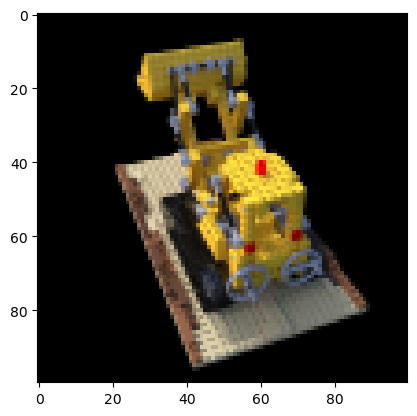

(106, 100, 100, 3)


In [5]:
# Load the data from the tiny nerf data set
data = np.load('./datasets/tiny_nerf_data.npz')
images, poses, focal = data['images'], data['poses'], data['focal']

height = np.shape(images)[1]
width = np.shape(images)[2]
# print(height)
# print(width)
# print(focal)
# print(np.shape(poses))
# plt.imshow(images[0])
plt.imshow(images[50])
plt.show()
print(np.shape(images))


![title](./images/positional_encoding.png)

In [6]:
#Positional encoding (p.g. 7 Section 5.1 of NERF Paper)
# L_val=4
L_val=6

def positional_encoding(x: torch.Tensor) -> torch.Tensor:
    x_array = [x]
#     print(x_array)
    for i in range(L_val):
        x_array.append(torch.sin(2.0**i * x))
        x_array.append(torch.cos(2.0**i * x))
    concat_x = torch.cat(x_array, -1)
    return concat_x   

def find_rays(width, height, focal, camera_frames):
    i, j = torch.meshgrid(torch.range(1, width), torch.range(1, height), indexing="xy")
#     i, j = torch.meshgrid(torch.range(width), torch.range(height), indexing="ij")
    width_over_focal = (i-width/2.0)/focal
    height_over_focal = -1 * (j - height/ 2.0)/focal
    dirs = torch.stack([width_over_focal, height_over_focal, -1 * torch.ones_like(i)], -1)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * camera_frames[:3,:3], -1)
    shape_of_rays_d = rays_d.size()
#     print(type(shape_of_rays_d))

#     print(shape_of_rays_d)
    from_third = torch.tensor(camera_frames[:3,-1])
#     print(type(from_third))
    rays_o = torch.broadcast_to(from_third, shape_of_rays_d)
    return rays_o, rays_d

def create_batches(points: torch.Tensor, model, chunk_size: int=32*1024) -> torch.Tensor:
    first_shape = points.size()[0]
    special_list = []
    for i in range(0, first_shape, chunk_size):
        grad = model(points[i:i+chunk_size])
#         print(grad.shape)
        special_list.append( grad )
    return torch.cat(special_list, 0)
#     return torch.cat([model(points[i:i+chunk_size]) for i in range(0, first_shape, chunk_size)], 0)
    
def render(rays_o, rays_d, model, near, far, num_samples):
    z_points = torch.linspace(near, far, num_samples)
    points = rays_o[...,None,:] + rays_d[...,None,:] * z_points[...,:,None]
    
    #flatten the points and use positional encoding
    new_points = positional_encoding(points.reshape((-1, 3)))

    batched = create_batches(new_points, model)
    #reshape the batched points
    get_last = list(points.size()[:-1])
    batched = batched.reshape(get_last + [4])
    
#     print(batched.shape)
    
    up_to_last = batched[..., 3]
    sigma = torch.sigmoid(up_to_last)
    rgb_values = torch.sigmoid(batched[..., :3])
    
    back_to_front = z_points[..., 1:] - z_points[..., :-1]
    broadcasted_vals = torch.broadcast_to(torch.tensor([1e10]), z_points[...,:1].size())
    
    distances = torch.cat([back_to_front, broadcasted_vals], -1)
    alphas = 1. - torch.exp(-1 * sigma * distances)
#     print(rgb_values.shape)

    inverse_alphas = 1.0 - alphas + 1e-10

    #TODO: Fix this for exclusive cum_prod
    probs = torch.cumprod(inverse_alphas, -1)
    probs = torch.roll(probs, 1, -1)
    probs[...,0] = 1.0
    weights = alphas * probs 
#     print(weights.shape)
#     print(alphas.shape)
    rgb_map = torch.sum(weights[...,None] * rgb_values, -2) 
    depth_map = torch.sum(weights * z_points, -1) 
    acc_map = torch.sum(weights, -1)
    
    return rgb_map, depth_map, acc_map

In [9]:
#Create the pytorch model
input_num = 2*3*L_val+3

class Nerf(nn.Module):
    def __init__(self, input_dim=input_num, output_dim=4, depth=8, nn_count=128):
        super(Nerf, self).__init__()
        self.depth = depth
        self.nn_count = nn_count
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, nn_count)
        self.linears = nn.ModuleList([nn.Linear(nn_count, nn_count) for i in range(depth - 2)])
        self.fc8 = nn.Linear(nn_count, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        for i, layers in enumerate(self.linears):
            out = layers(out)
            out = self.relu(out)
        out = self.fc8(out)
        return out

![title](./images/adam.png)

/home/li.pet/.conda/envs/mini-nerf/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  from ipykernel import kernelapp as app
/home/li.pet/.conda/envs/mini-nerf/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/li.pet/.conda/envs/mini-nerf/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss: tensor(0.1811, grad_fn=<MseLossBackward0>)


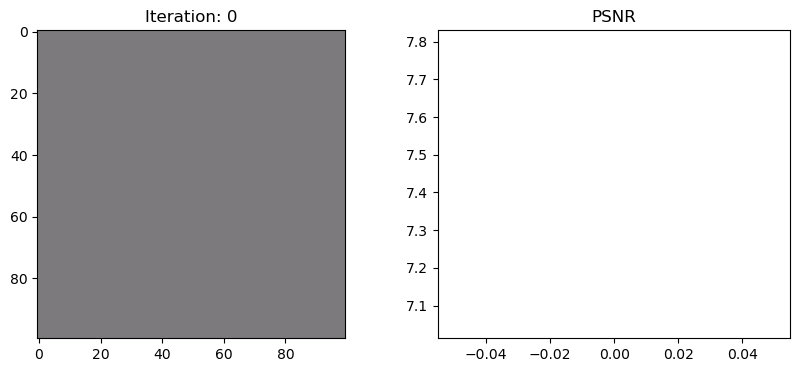

Loss: tensor(0.0664, grad_fn=<MseLossBackward0>)


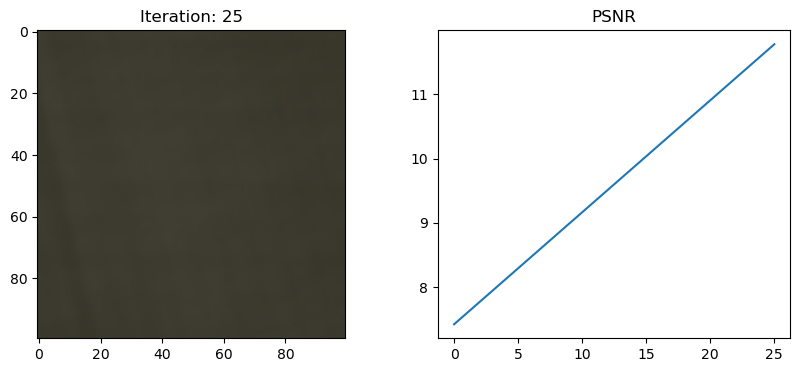

Loss: tensor(0.0625, grad_fn=<MseLossBackward0>)


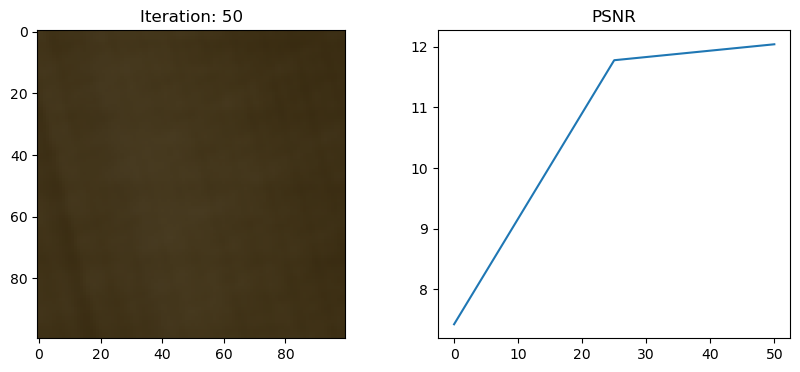

Loss: tensor(0.1048, grad_fn=<MseLossBackward0>)


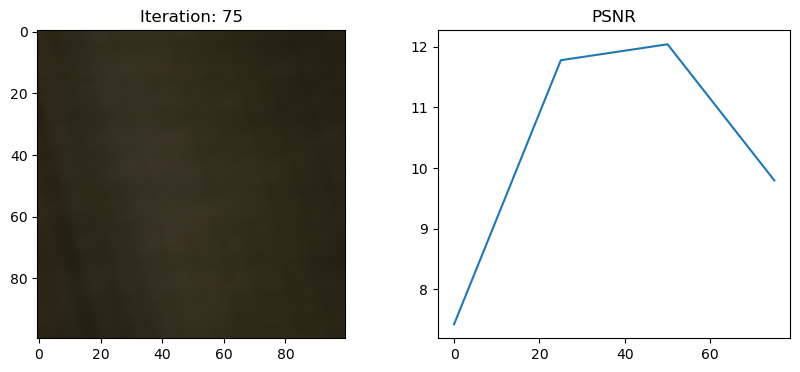

Loss: tensor(0.0202, grad_fn=<MseLossBackward0>)


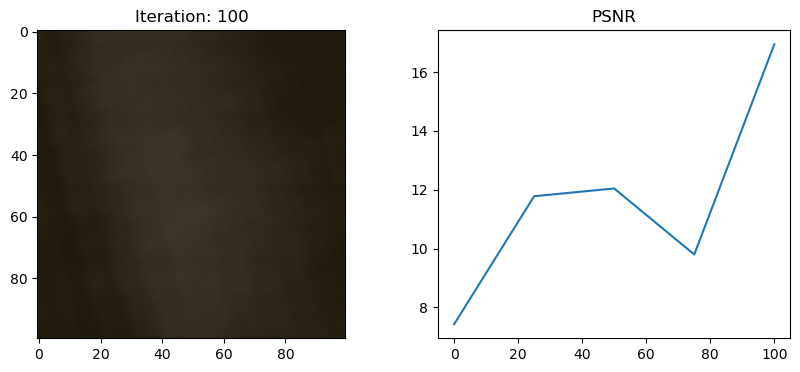

Loss: tensor(0.0416, grad_fn=<MseLossBackward0>)


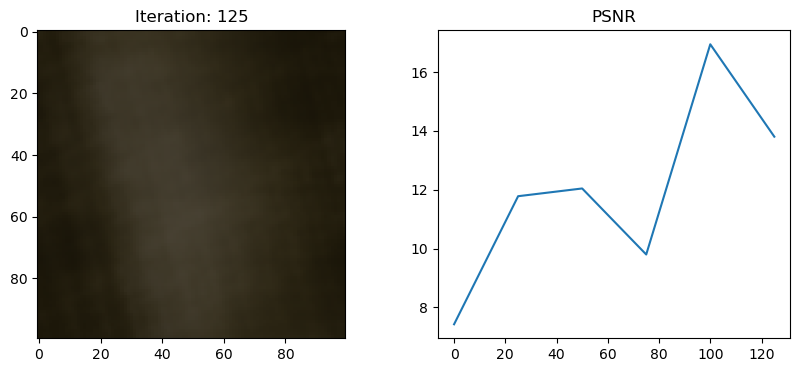

Loss: tensor(0.0406, grad_fn=<MseLossBackward0>)


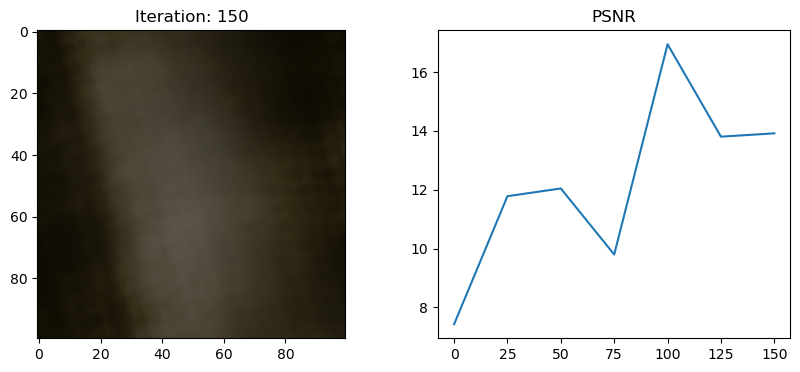

Loss: tensor(0.0454, grad_fn=<MseLossBackward0>)


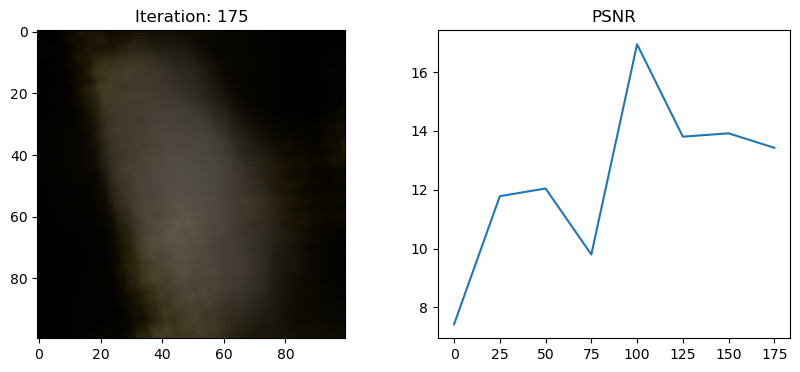

Loss: tensor(0.0334, grad_fn=<MseLossBackward0>)


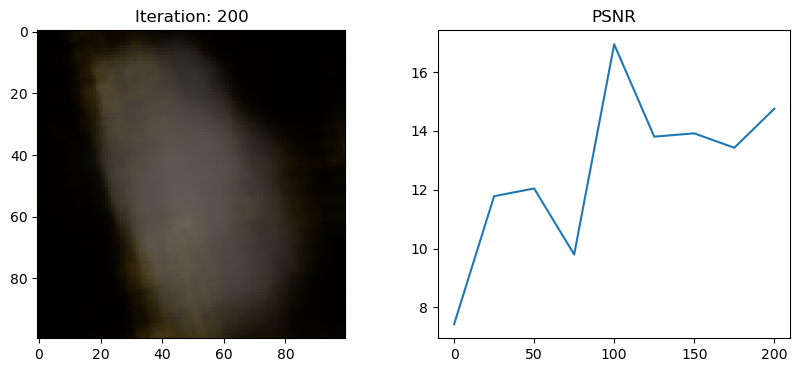

Loss: tensor(0.0654, grad_fn=<MseLossBackward0>)


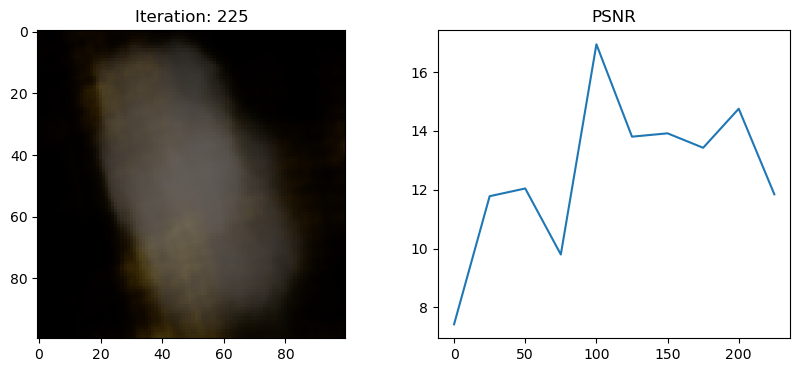

Loss: tensor(0.0256, grad_fn=<MseLossBackward0>)


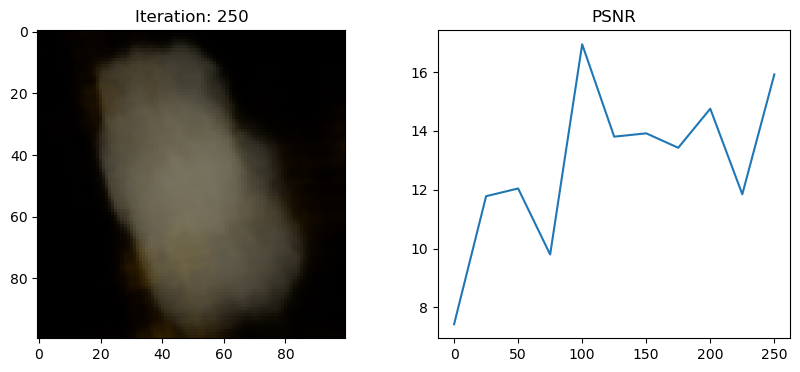

Loss: tensor(0.0136, grad_fn=<MseLossBackward0>)


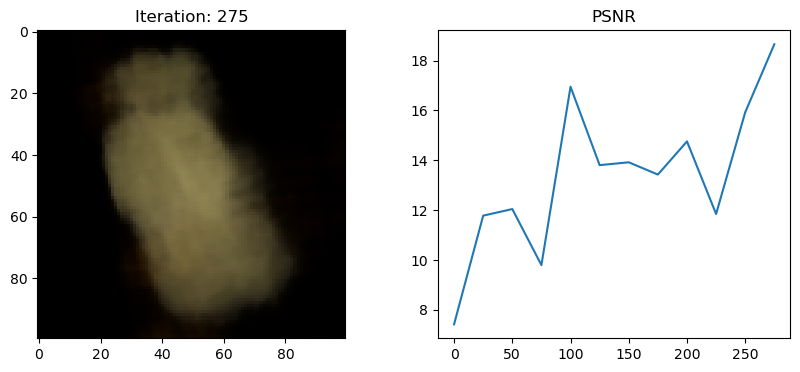

Loss: tensor(0.0238, grad_fn=<MseLossBackward0>)


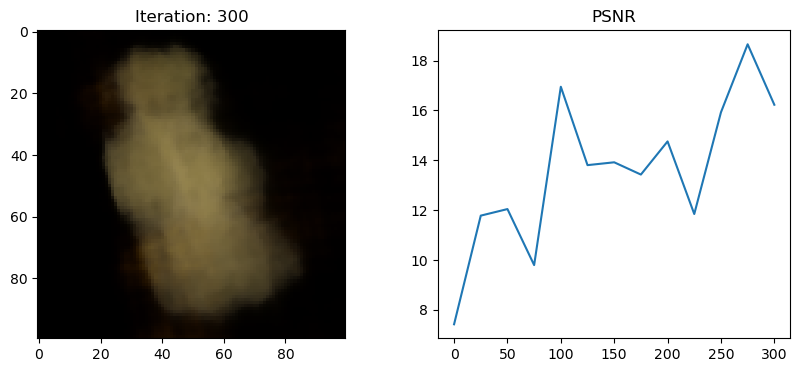

Loss: tensor(0.0121, grad_fn=<MseLossBackward0>)


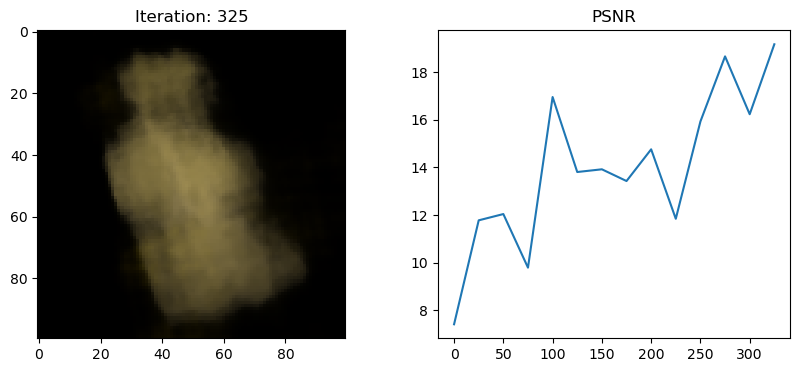

Loss: tensor(0.0189, grad_fn=<MseLossBackward0>)


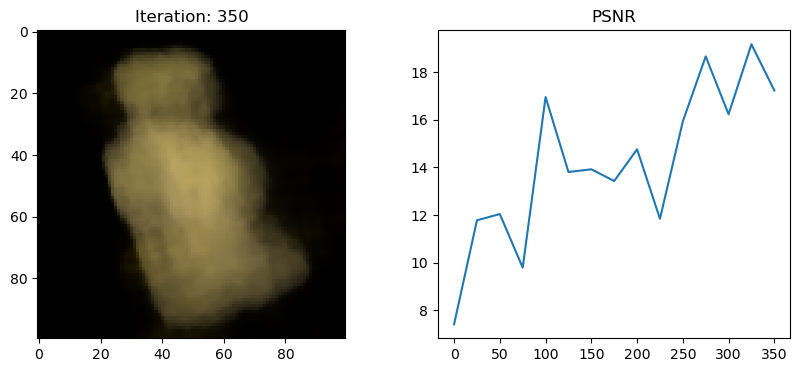

Loss: tensor(0.0330, grad_fn=<MseLossBackward0>)


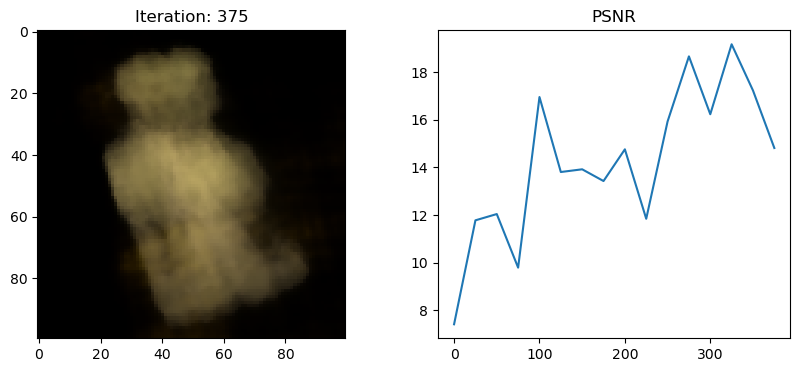

Loss: tensor(0.0269, grad_fn=<MseLossBackward0>)


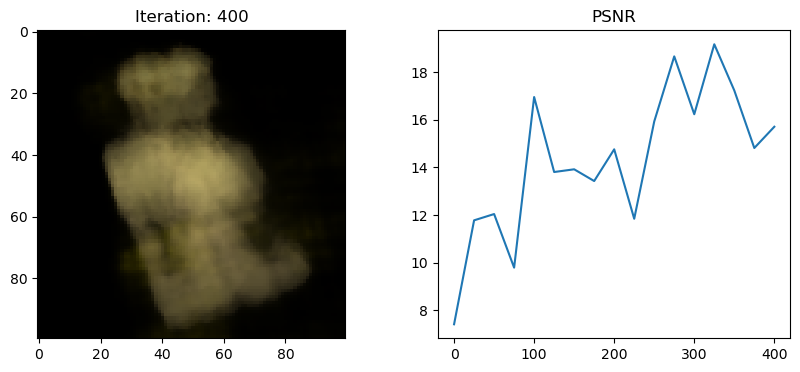

Loss: tensor(0.0255, grad_fn=<MseLossBackward0>)


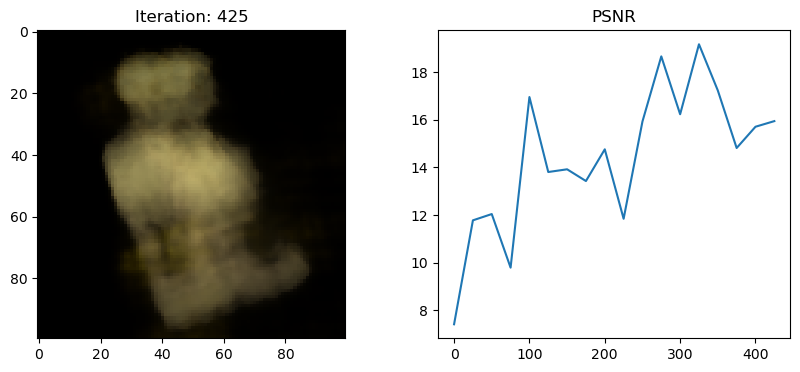

Loss: tensor(0.0177, grad_fn=<MseLossBackward0>)


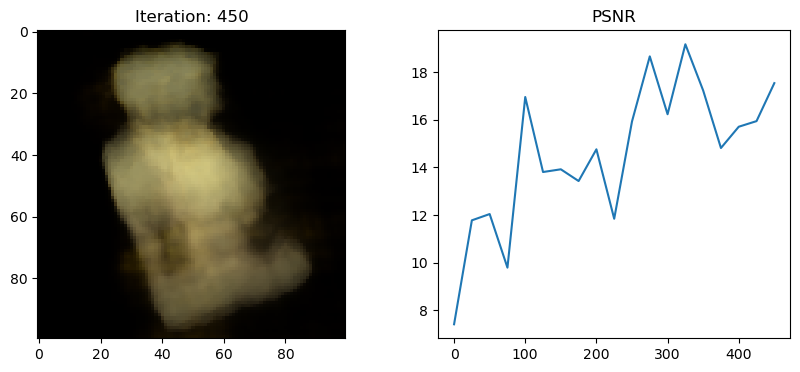

Loss: tensor(0.0158, grad_fn=<MseLossBackward0>)


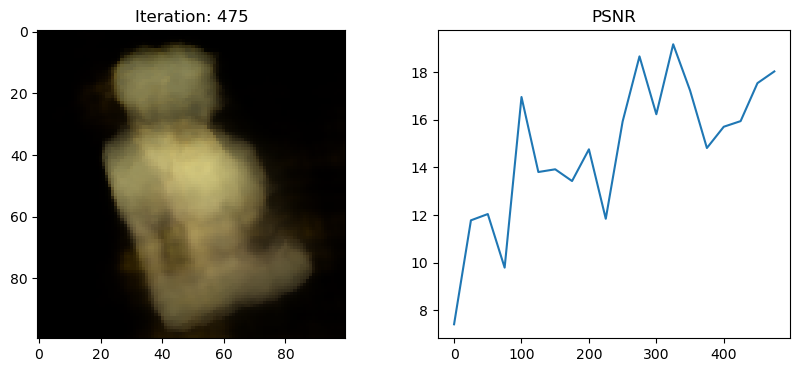

Loss: tensor(0.0239, grad_fn=<MseLossBackward0>)


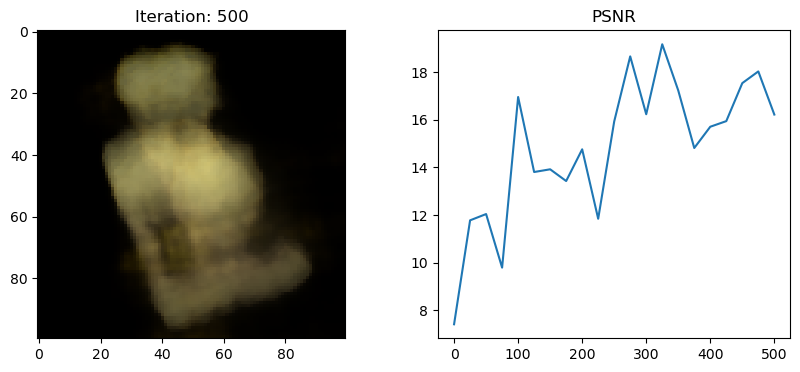

Loss: tensor(0.0242, grad_fn=<MseLossBackward0>)


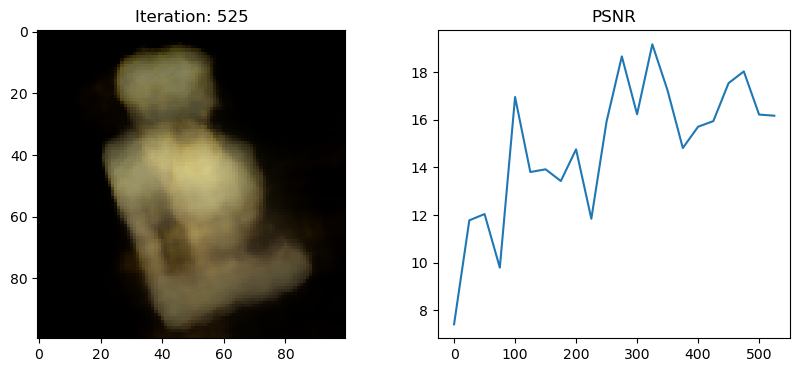

Loss: tensor(0.0128, grad_fn=<MseLossBackward0>)


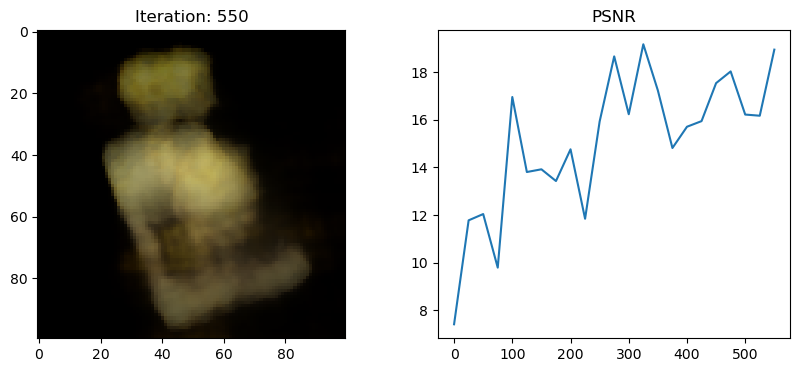

Loss: tensor(0.0161, grad_fn=<MseLossBackward0>)


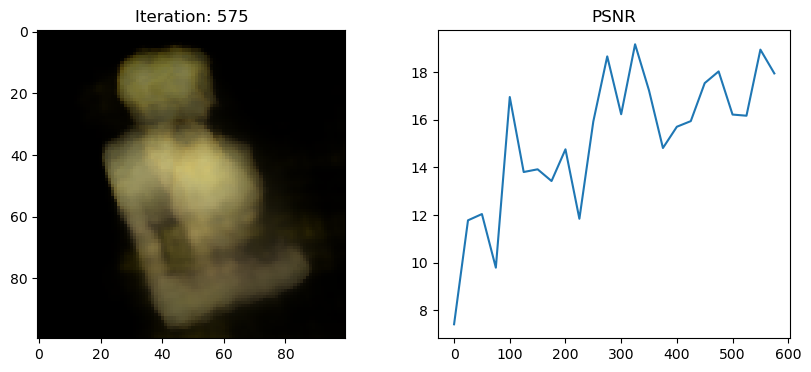

Loss: tensor(0.0171, grad_fn=<MseLossBackward0>)


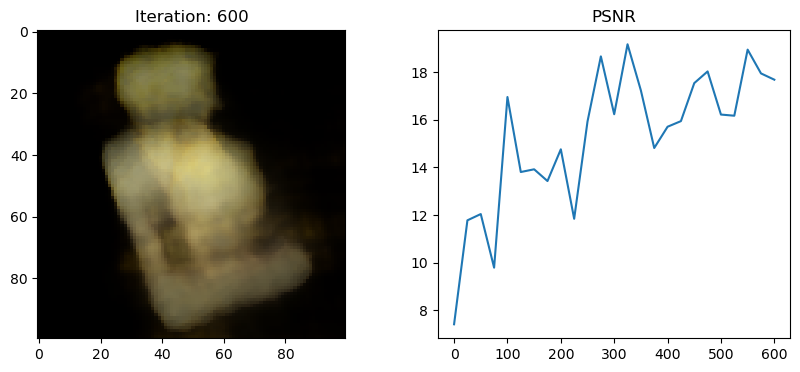

Loss: tensor(0.0179, grad_fn=<MseLossBackward0>)


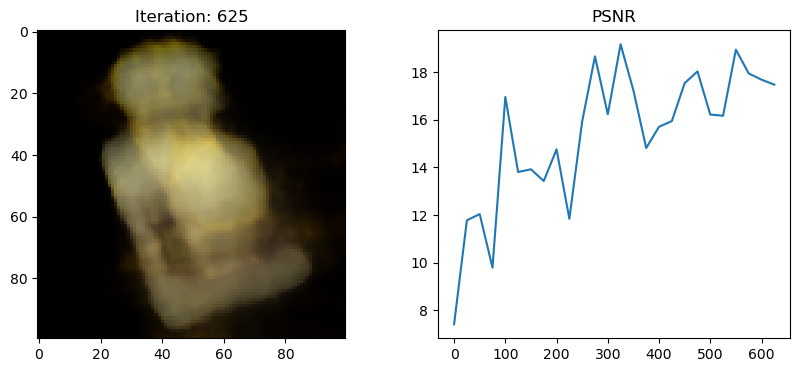

Loss: tensor(0.0232, grad_fn=<MseLossBackward0>)


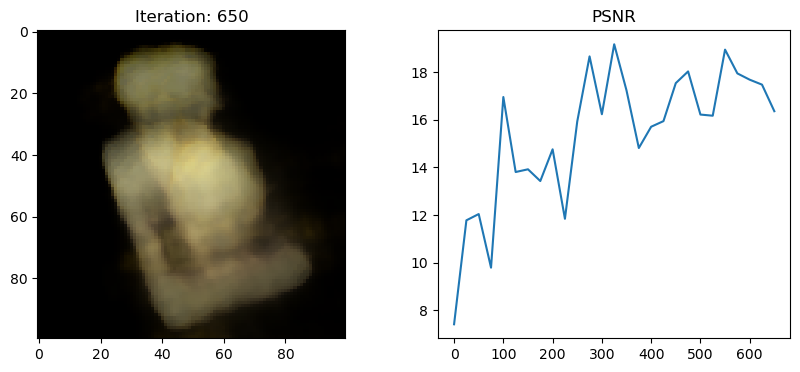

Loss: tensor(0.0151, grad_fn=<MseLossBackward0>)


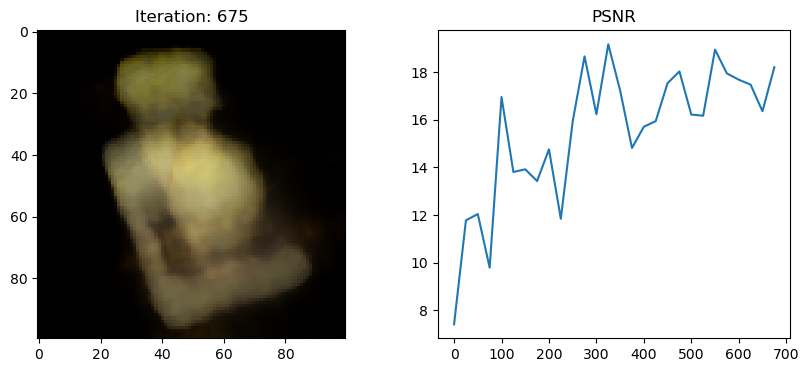

Loss: tensor(0.0250, grad_fn=<MseLossBackward0>)


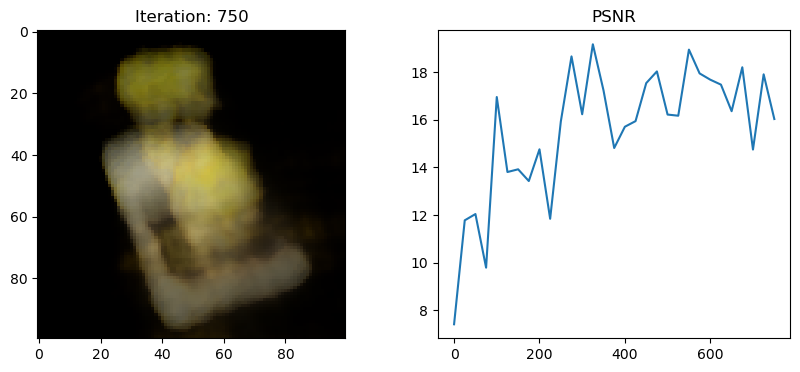

Loss: tensor(0.0160, grad_fn=<MseLossBackward0>)


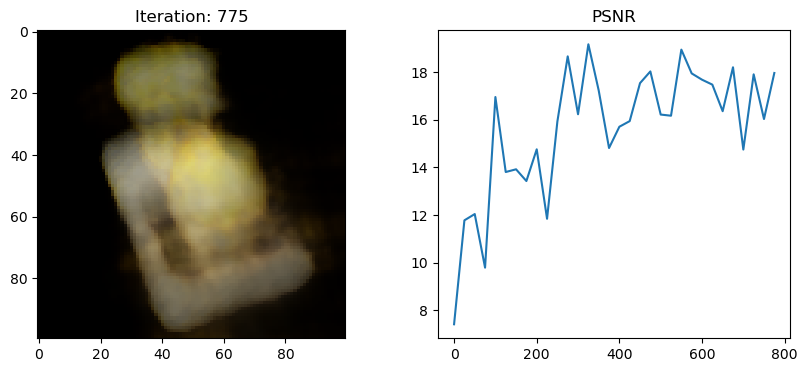

Loss: tensor(0.0284, grad_fn=<MseLossBackward0>)


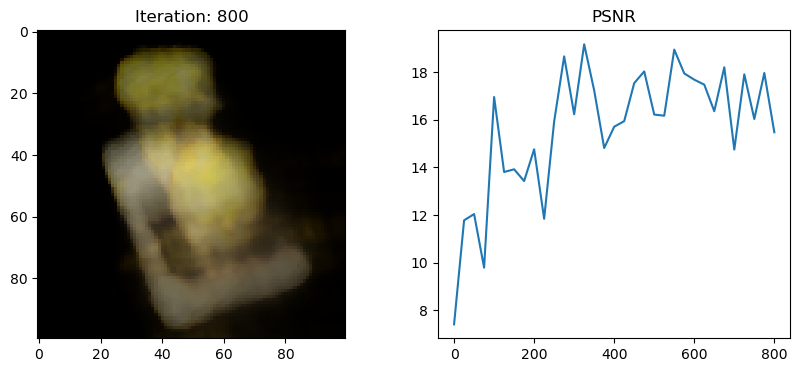

Loss: tensor(0.0328, grad_fn=<MseLossBackward0>)


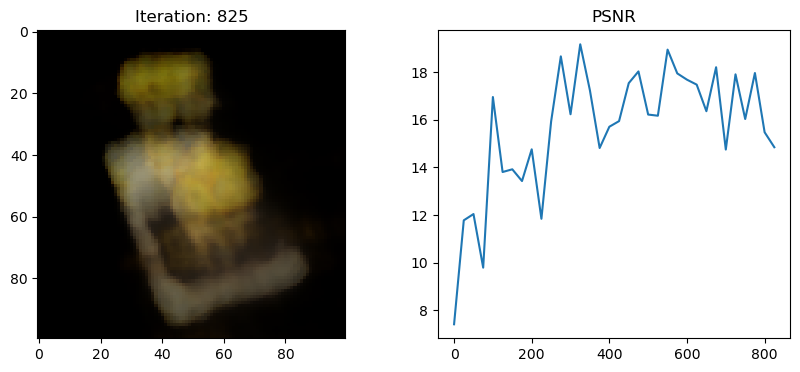

Loss: tensor(0.0132, grad_fn=<MseLossBackward0>)


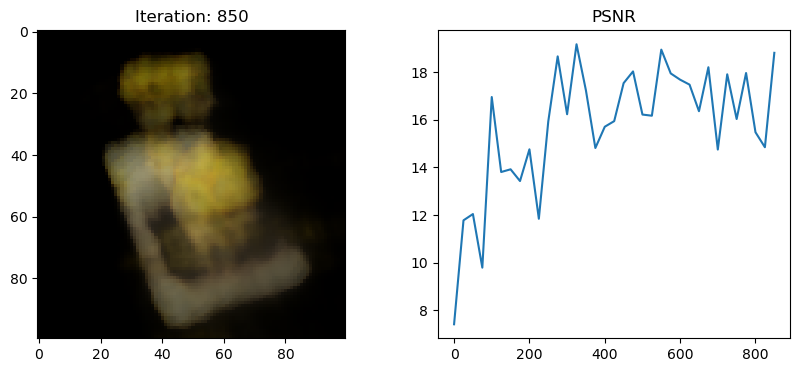

Loss: tensor(0.0159, grad_fn=<MseLossBackward0>)


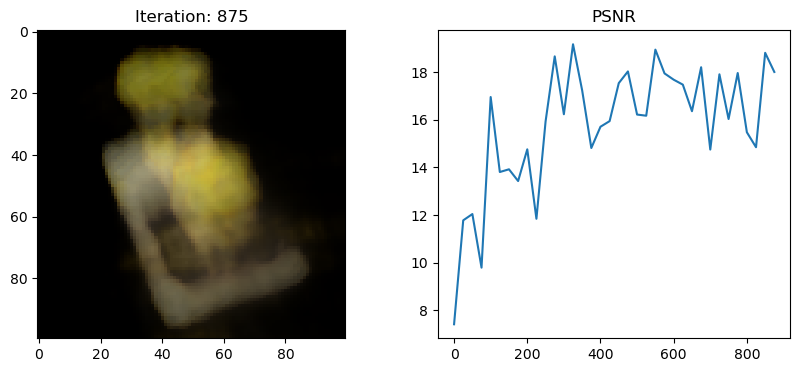

Loss: tensor(0.0208, grad_fn=<MseLossBackward0>)


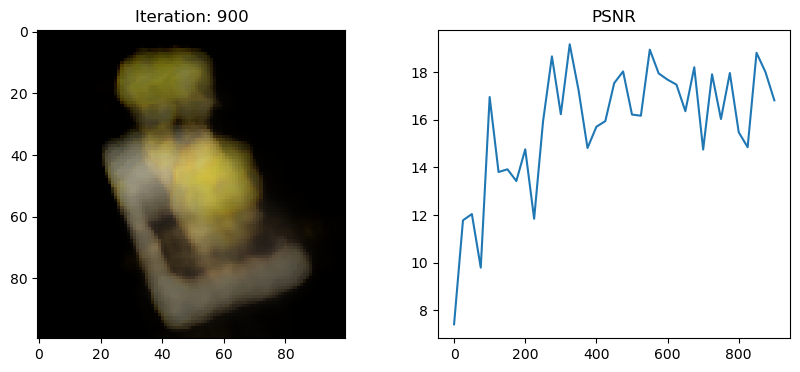

Loss: tensor(0.0275, grad_fn=<MseLossBackward0>)


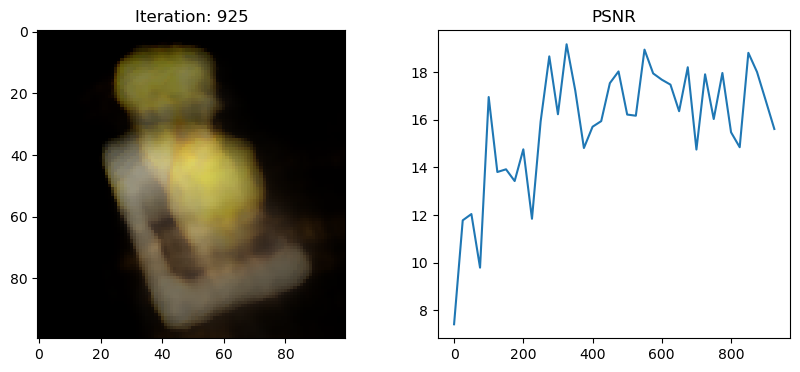

Loss: tensor(0.0176, grad_fn=<MseLossBackward0>)


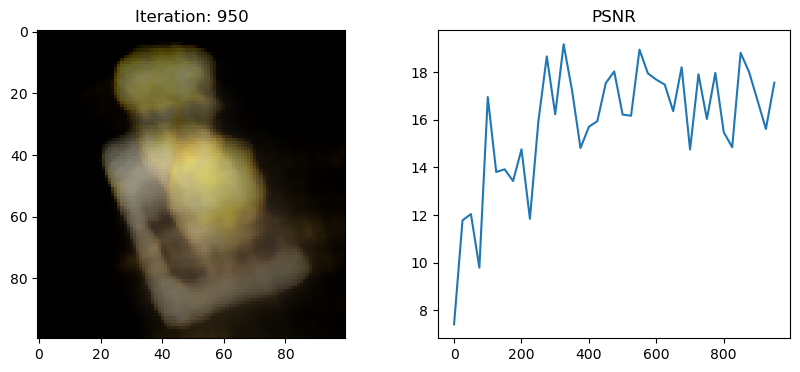

Loss: tensor(0.0161, grad_fn=<MseLossBackward0>)


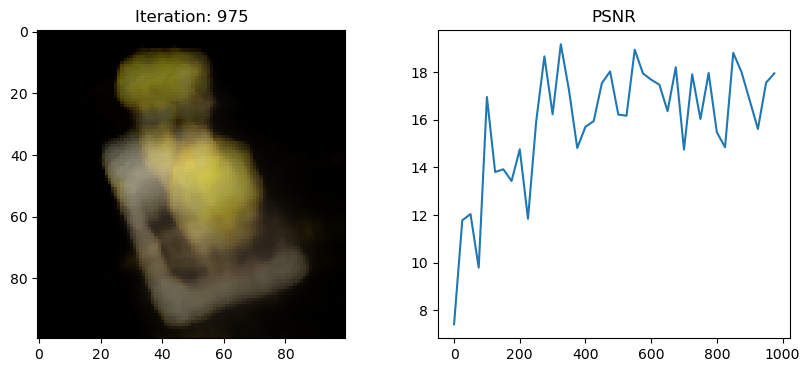

Loss: tensor(0.0143, grad_fn=<MseLossBackward0>)


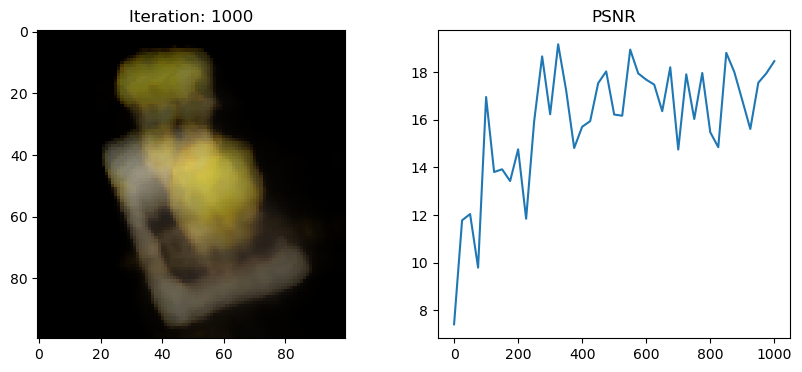

NameError: name 'PATH' is not defined

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Nerf()
model.to(device)

num_samples = 64
n_iters = 1000
learning_rate = 5e-4
psnrs = []
iternums = []

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(n_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = torch.tensor(images[img_i]).to(device)
    pose = torch.tensor(poses[img_i]).to(device)
    rays_o, rays_d = find_rays(height=height, width=width, focal=focal, camera_frames=pose)
    
    rgb, depth, acc = render(rays_o=rays_o, rays_d=rays_d, model=model, near=2., far=6., num_samples=num_samples)
#     print(rgb)
#     print(target)
    loss = criterion(rgb, torch.tensor(target))
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % 25 == 0:
        with torch.no_grad():
            print('Loss: ' + str(loss))
            t = time.time()

            rays_o, rays_d = find_rays(height=height, width=width, focal=focal, camera_frames=poses[50])
            rgb, depth, acc = render(rays_o=rays_o, rays_d=rays_d, model=model, near=2., far=6., num_samples=num_samples)
            psnr = -10. * torch.log(loss) / torch.log(torch.tensor(10.))

            psnrs.append(psnr.detach().numpy())
            iternums.append(epoch)

            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb.detach().cpu().numpy())
            plt.title(f'Iteration: {epoch}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()
torch.save(model.state_dict(), PATH)
torch.save(train_psnrs, 'trained_models/train_psnrs_tiny.pt')
torch.save(val_psnrs, 'trained_models/val_psnrs_tiny.pt')

print('Done')


ValueError: x and y must have same first dimension, but have shapes (500,) and (41,)

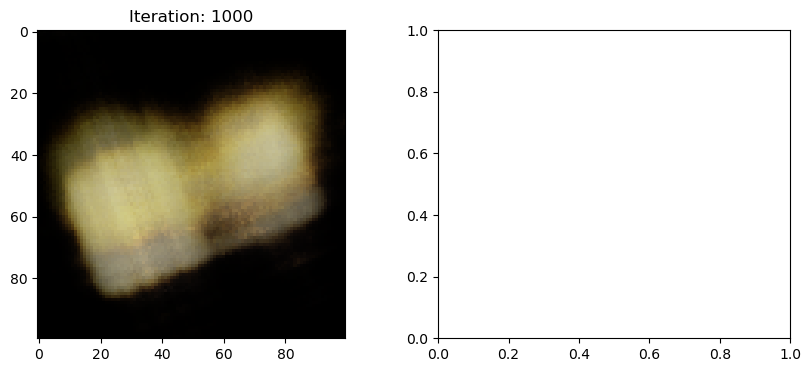

In [15]:
outputs = torch.load('src/trained_models/outputs.pt')
train_psnrs = torch.load('src/trained_models/train_psnrs_1000.pt')
val_psnrs = torch.load('src/trained_models/val_psnrs_1000.pt')

from models import *
from preprocessing import *
from forward import *
from rendering import *

rgb_predicted = outputs['rgb_map']
iternums = list(range(1, 501))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(rgb_predicted.reshape([height, width, 3]).detach().numpy())
plt.title(f'Iteration: {epoch}')
plt.subplot(122)
plt.plot(iternums, psnrs)
plt.title('PSNR')
plt.show()